## Модель Хольта-Уинтерса
Описание:
Модель Хольта-Уинтерса, также известная как экспоненциальное сглаживание (Exponential Smoothing) второго порядка, является методом прогнозирования временных рядов. Модель Хольта-Уинтерса включает три основных компонента: уровень (level), тренд (trend) и сезонность (seasonality).

План работ:
1. Подготовить данные
2. Написать функцию предсказания
3. Подобрать оптимальные гиперпараметры

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the ticker symbol for Apple
ticker_symbol = "AAPL"

# Set the start and end dates for the data
start_date = "2022-01-01"
end_date = "2022-12-31"

# Fetch historical data
apple_data = yf.download(ticker_symbol, start=start_date, end=end_date)

ts = apple_data['Close'].values[:-5]
time = np.arange(len(ts))

/Library/Python/3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

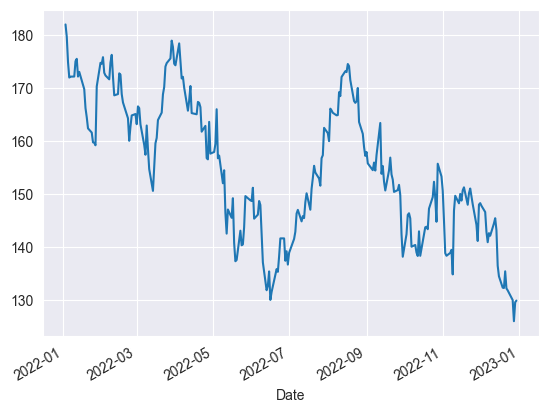

In [2]:
apple_data['Close'].plot()

### Построим регрессию для инициализации параметров

In [3]:
print(len(ts))

246


In [4]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(time.reshape(-1, 1), ts.reshape(-1, 1))

LinearRegression()

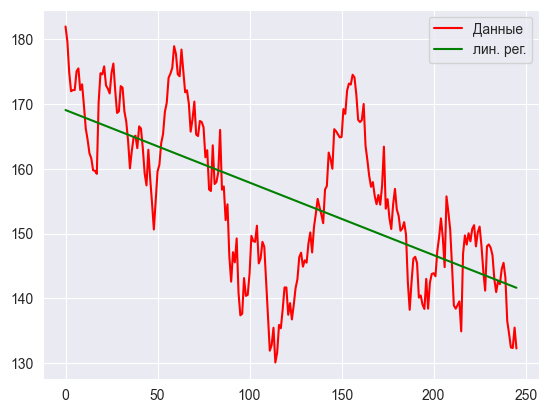

In [5]:
a0, b0 = lr.coef_, lr.intercept_
xl = (a0 * time + b0)[0]
plt.plot(ts, color='red', label='Данные')
plt.plot(xl, color='green', label='лин. рег.')
plt.legend()
plt.show()

In [6]:
L = 5 # 5 рабочих дней длина периода
k = len(ts) // L 

In [7]:
F_init = []

for p in range(L):
    temp = []
    for i in range(k):
        temp.append(ts[i*L - p] / xl[i*L - p])
    
    F_init.append(1/k * sum(temp))
    
F_init = np.array(F_init).T[0]

In [8]:
b = np.zeros(len(ts))
b[0] = b0

a = np.zeros(len(ts))
a[0] = a0

F = np.zeros(len(ts)+L-2)
F[:L] = F_init

alpha, beta, gamma = 0.3, 0.4, 0.3

for t in range(1, len(ts)):
    b[t] = alpha * ts[t]/F[t] + (1 - alpha) * (b[t-1] + a[t-1])
    a[t] = beta * (b[t] - b[t-1]) + (1 - beta) * a[t-1]
    F[t+L-2] = gamma * ts[t]/b[t] + (1 - gamma) * F[t]

In [9]:
ts_hat = []
for t in range(1, len(ts)):
    ts_hat.append((a[t] + b[t]) * F[t])

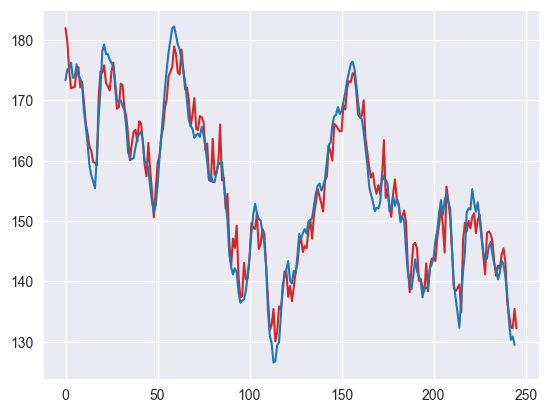

In [10]:
plt.plot(ts, color='tab:red')
plt.plot(ts_hat, color='tab:blue')
plt.show()

То что выше можно удалить, оформим функцией

In [11]:
def Holt_Winters(ts, time, L, tau, alpha, beta, gamma):
    lr = LinearRegression()
    lr.fit(time.reshape(-1, 1), ts.reshape(-1, 1))
    a0, b0 = lr.coef_, lr.intercept_
    
    xl = (a0 * time + b0)[0]
    k = len(ts) // L
    
    F_init = []

    for p in range(L):
        temp = []
        for i in range(k):
            temp.append(ts[i*L - p] / xl[i*L - p])
        
        F_init.append(1/k * sum(temp))
        
    F_init = np.array(F_init).T[0]
    
    
    b = np.zeros(len(ts))
    b[0] = b0

    a = np.zeros(len(ts))
    a[0] = a0

    F = np.zeros(len(ts)+L-2)
    F[:L] = F_init

    for t in range(1, len(ts)):
        b[t] = alpha * ts[t]/F[t] + (1 - alpha) * (b[t-1] + a[t-1])
        a[t] = beta * (b[t] - b[t-1]) + (1 - beta) * a[t-1]
        F[t+L-2] = gamma * ts[t]/b[t] + (1 - gamma) * F[t]
    
    
    ts_hat = []
    for t in range(1, len(ts)):
        ts_hat.append((a[t] + b[t]) * F[t])

    # F[(np.arange(tau)+1 - L)]
    prediction = (a[-1]*(np.arange(tau)+1) + b[-1]) * F[-L + np.arange(tau)]   
    
    return a, b, F, ts_hat, prediction

In [12]:
tau, alpha, beta, gamma = 5, 0.3, 0.4, 0.3

a, b, F, ts_hat, prediction = Holt_Winters(ts, time, L, tau, alpha, beta, gamma)

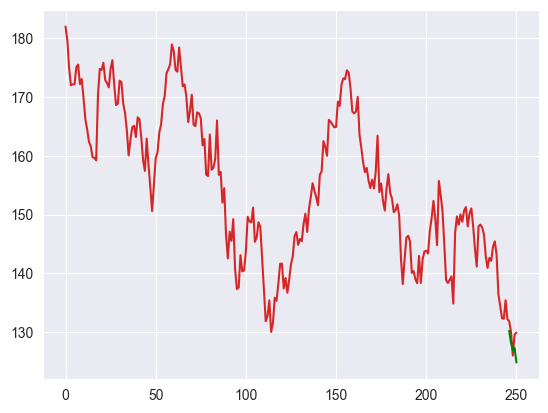

In [13]:
plt.plot(apple_data['Close'].values, color='tab:red')
plt.plot(np.arange(tau)+len(ts), prediction, color='green')
plt.show()

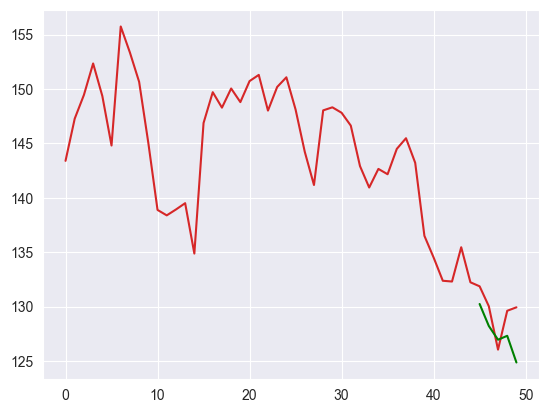

In [14]:
plt.plot(apple_data['Close'].values[-50:], color='tab:red')
plt.plot(np.arange(tau)+45, prediction, color='green')
plt.show()

Тюнинг гиперпараметров

In [15]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [23]:
train, test = ts, apple_data['Close'].values[-5:]

In [24]:
# функция, которую будем минимизировать. Цель: найти лучшие гиперпараметры для предсказываемого периода
def target_fun(alpha, beta, gamma):
    a, b, F, ts_hat, prediction = Holt_Winters(train, np.arange(len(train)), L, 5, alpha, beta, gamma)
    
    return np.sqrt(mean_squared_error(prediction, test))

In [25]:
opt = minimize(lambda x: target_fun(x[0], x[1], x[2]), bounds=[(0, 1), (0, 1), (0, 1)], x0=[0.3, 0.4, 0.3])

In [26]:
opt.x

array([0.37949496, 0.55413092, 0.39599412])

In [27]:
a, b, F, ts_hat, prediction = Holt_Winters(train, np.arange(len(train)), L, 5, opt.x[0], opt.x[1], opt.x[2])

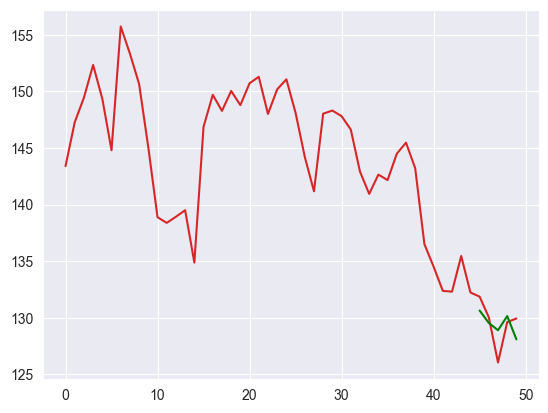

In [28]:
plt.plot(apple_data['Close'].values[-50:], color='tab:red')
plt.plot(np.arange(tau)+45, prediction, color='green')
plt.show()

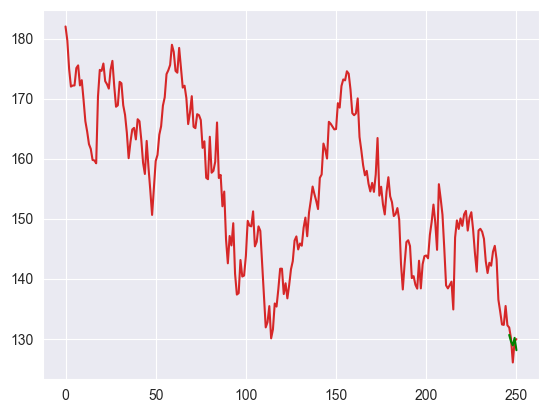

In [29]:
plt.plot(apple_data['Close'].values, color='tab:red')
plt.plot(np.arange(tau)+len(ts), prediction, color='green')
plt.show()